In [1]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder.getOrCreate()

24/04/01 18:21:33 WARN Utils: Your hostname, Macbooks-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.5.50.135 instead (on interface en0)
24/04/01 18:21:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/01 18:21:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
# data = spark.read.csv("./sample_data - one_year.csv", header=True)
data = spark.read.csv("./sample_data - one_year.csv", header=True, inferSchema=True)

In [4]:
# if we prepare working with sql
data.createTempView("vw_dataset")

# Understand dataset

In [5]:
data.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: boolean (nullable = true)
 |-- monthly_income: double (nullable = true)
 |-- emp_industry: string (nullable = true)
 |-- age: integer (nullable = true)



## Get a few row

### By dataframe python api

In [6]:
data.show(2)

+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|annual_inc|issue_d|loan_status|    monthly_income|emp_industry|age|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|     5000| 36 months|   13.56|     169.83|    C|       C1|Public Affairs Sp...| 10+ years|  175000.0| Aug-18|      false|14583.333333333334|       other| 33|
|     4000| 36 months|    10.9|     130.77|    B|       B4|     Reception/Sales|    1 year|   25000.0| Mar-18|       true|2083.3333333333335|       other| 21|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
only showing top 2 rows



### By Spark SQL

In [7]:
spark.sql("select * from vw_dataset limit 2").show();

+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|loan_amnt|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|annual_inc|issue_d|loan_status|    monthly_income|emp_industry|age|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+
|     5000| 36 months|   13.56|     169.83|    C|       C1|Public Affairs Sp...| 10+ years|  175000.0| Aug-18|      false|14583.333333333334|       other| 33|
|     4000| 36 months|    10.9|     130.77|    B|       B4|     Reception/Sales|    1 year|   25000.0| Mar-18|       true|2083.3333333333335|       other| 21|
+---------+----------+--------+-----------+-----+---------+--------------------+----------+----------+-------+-----------+------------------+------------+---+



## Get a few columns

### By dataframe python api

In [8]:
data.select("loan_amnt", "term").show(10)

+---------+----------+
|loan_amnt|      term|
+---------+----------+
|     5000| 36 months|
|     4000| 36 months|
|     5000| 36 months|
|     5500| 36 months|
|    11200| 60 months|
|    36000| 60 months|
|    21925| 36 months|
|    10000| 36 months|
|     7925| 36 months|
|    10000| 36 months|
+---------+----------+
only showing top 10 rows



### By Spark SQL

In [9]:
df = spark.sql("select loan_amnt, term from vw_dataset")

In [10]:
df.select("*").show(2)

+---------+----------+
|loan_amnt|      term|
+---------+----------+
|     5000| 36 months|
|     4000| 36 months|
+---------+----------+
only showing top 2 rows



# Analyse data

## Loan group

In [11]:
from pyspark.sql.functions import when
new_df = data.withColumn("loan_group", when(data.loan_amnt > 5000, "big amount").otherwise("small amount"))

In [12]:
new_df.select("loan_group", "loan_amnt").groupby('loan_group').count().show()

+------------+-----+
|  loan_group|count|
+------------+-----+
|small amount| 6513|
|  big amount|43011|
+------------+-----+



<Axes: ylabel='Frequency'>

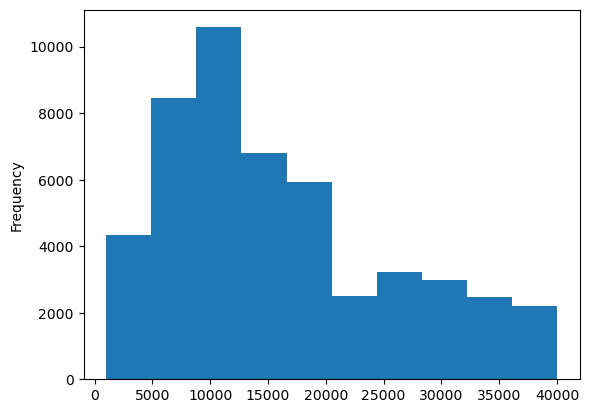

In [13]:
new_df.toPandas()['loan_amnt'].plot.hist()

## What is the average amount of Rejected Loan and approved loan?

In [14]:
data.select("loan_status", "loan_amnt").groupBy("loan_status").mean().show()

+-----------+------------------+
|loan_status|    avg(loan_amnt)|
+-----------+------------------+
|       true| 17016.26348665531|
|      false|15963.130848007073|
+-----------+------------------+



<Axes: xlabel='loan_amnt', ylabel='Count'>

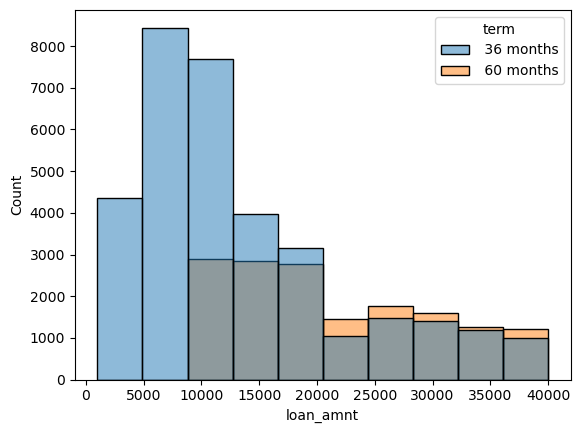

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = data.toPandas()

sns.histplot(pandas_df, x= pandas_df['loan_amnt'], hue='term', bins=10)

## Which employment title that likely to be rejected for the loan?

In [16]:
whole_count = data.groupby( "emp_title").count().sort(["count"], ascending=False)
whole_count.show(2)

+---------+-----+
|emp_title|count|
+---------+-----+
|    other| 5709|
|  Manager|  883|
+---------+-----+
only showing top 2 rows



In [17]:
reject_count = data.filter(data.loan_status == False).groupby( "emp_title").count().sort(["count"], ascending=False)
reject_count.show(3)

+---------+-----+
|emp_title|count|
+---------+-----+
|    other| 4486|
|  Manager|  715|
|  Teacher|  711|
+---------+-----+
only showing top 3 rows



In [18]:
w_count = whole_count.selectExpr("emp_title as w_emp_title", "count as w_count") 

df = w_count \
 .join(reject_count, w_count.w_emp_title == reject_count.emp_title)
df.show(3)

+--------------------+-------+--------------------+-----+
|         w_emp_title|w_count|           emp_title|count|
+--------------------+-------+--------------------+-----+
|Training Specialist |      3|Training Specialist |    3|
|           Physician|     35|           Physician|   32|
|           machinist|     16|           machinist|   14|
+--------------------+-------+--------------------+-----+
only showing top 3 rows



In [19]:
from pyspark.sql.functions import col

(df
 .withColumn("rejected_percentage", df["count"] / df.w_count )
 .filter(df.w_count >100)
 .sort("rejected_percentage", ascending=False)
 .show(10)
)

+--------------------+-------+--------------------+-----+-------------------+
|         w_emp_title|w_count|           emp_title|count|rejected_percentage|
+--------------------+-------+--------------------+-----+-------------------+
|            Director|    159|            Director|  141| 0.8867924528301887|
|      Office Manager|    242|      Office Manager|  214| 0.8842975206611571|
|               Nurse|    138|               Nurse|  120| 0.8695652173913043|
|    Registered Nurse|    364|    Registered Nurse|  316| 0.8681318681318682|
|     General Manager|    194|     General Manager|  168|  0.865979381443299|
|     Project Manager|    212|     Project Manager|  183| 0.8632075471698113|
|       Sales Manager|    123|       Sales Manager|  106| 0.8617886178861789|
|             Teacher|    828|             Teacher|  711| 0.8586956521739131|
|Administrative As...|    105|Administrative As...|   90| 0.8571428571428571|
|                  RN|    288|                  RN|  244| 0.8472

In [20]:
from pyspark.sql.functions import col

w_count = whole_count.selectExpr("emp_title as w_emp_title", "count as w_count") 
reject_probability = (w_count
 .join(reject_count, w_count.w_emp_title == reject_count.emp_title)
 .withColumn("rejected_percentage", col("count")/ col("w_count"))
 .filter(col("w_count") >10)
 .sort("rejected_percentage", ascending=False)
)
reject_probability.show(10)

+--------------------+-------+--------------------+-----+-------------------+
|         w_emp_title|w_count|           emp_title|count|rejected_percentage|
+--------------------+-------+--------------------+-----+-------------------+
|Special Education...|     15|Special Education...|   15|                1.0|
|          Bartender |     17|          Bartender |   17|                1.0|
|  Assistant Director|     12|  Assistant Director|   12|                1.0|
|            Sergeant|     12|            Sergeant|   12|                1.0|
|           Marketing|     12|           Marketing|   12|                1.0|
|Speech Language P...|     11|Speech Language P...|   11|                1.0|
|    Office Assistant|     12|    Office Assistant|   12|                1.0|
|Human Resources M...|     16|Human Resources M...|   16|                1.0|
|     Police officer |     14|     Police officer |   14|                1.0|
| Associate Professor|     17| Associate Professor|   17|       

In [21]:
reject_probability.printSchema()

root
 |-- w_emp_title: string (nullable = true)
 |-- w_count: long (nullable = false)
 |-- emp_title: string (nullable = true)
 |-- count: long (nullable = false)
 |-- rejected_percentage: double (nullable = true)



<Axes: xlabel='rejected_percentage', ylabel='Count'>

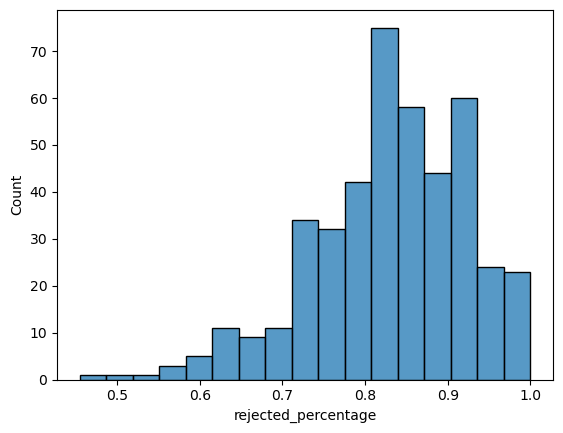

In [22]:
pd_reject = reject_probability.toPandas()
sns.histplot(pd_reject, x=pd_reject['rejected_percentage'], stat="count")

## Does the loan status impacted by employment title or not?

In [23]:
# Base in asumption, employment title does not impact much to loan status

## Which grades that likely to be approve for the loan?

In [32]:
approve_loan = data.filter(data["loan_status"] == True).select("grade").groupby("grade").count()
approve_loan.show()

+-----+-----+
|grade|count|
+-----+-----+
|    F|  237|
|    E|  876|
|    B| 1768|
|    D| 2482|
|    C| 2730|
|    A|  656|
|    G|   56|
+-----+-----+



In [44]:
data.select("grade").groupby("grade").count().show(2)

+-----+-----+
|grade|count|
+-----+-----+
|    F|  502|
|    E| 2409|
+-----+-----+
only showing top 2 rows



In [43]:
all_loan_by_grade = data.select("grade").groupby("grade").count().selectExpr("grade as all_loan_grade", "count as all_loan_count")
all_loan_by_grade.show()

+--------------+--------------+
|all_loan_grade|all_loan_count|
+--------------+--------------+
|             F|           502|
|             E|          2409|
|             B|         13481|
|             D|          8154|
|             C|         13103|
|             A|         11781|
|             G|            94|
+--------------+--------------+



In [48]:
# joint_dataset = all_loan_by_grade.join(approve_loan, all_loan_by_grade.all_loan_grade == approve_loan.grade) 

joint_dataset = all_loan_by_grade.join(approve_loan, all_loan_by_grade["all_loan_grade"] == approve_loan["grade"])
joint_dataset.show()

+--------------+--------------+-----+-----+
|all_loan_grade|all_loan_count|grade|count|
+--------------+--------------+-----+-----+
|             F|           502|    F|  237|
|             E|          2409|    E|  876|
|             B|         13481|    B| 1768|
|             D|          8154|    D| 2482|
|             C|         13103|    C| 2730|
|             A|         11781|    A|  656|
|             G|            94|    G|   56|
+--------------+--------------+-----+-----+



In [56]:
joint_dataset.withColumn("percentage", joint_dataset["count"] / joint_dataset["all_loan_count"]).sort("percentage", ascending=False).show()

+--------------+--------------+-----+-----+--------------------+
|all_loan_grade|all_loan_count|grade|count|          percentage|
+--------------+--------------+-----+-----+--------------------+
|             G|            94|    G|   56|  0.5957446808510638|
|             F|           502|    F|  237|  0.4721115537848606|
|             E|          2409|    E|  876| 0.36363636363636365|
|             D|          8154|    D| 2482|  0.3043904831984302|
|             C|         13103|    C| 2730| 0.20834923300007632|
|             B|         13481|    B| 1768| 0.13114754098360656|
|             A|         11781|    A|  656|0.055682879212290974|
+--------------+--------------+-----+-----+--------------------+



## What are applicant's grades within dataset?

## What are minimun and maximum interest rate in the datasets?

## What are minimun and maximum interest rate in the rejected loan?

## What are minimun and maximum interest rate in the approved loan?

# If prefer to work with pandas

In [ ]:
data.to_pandas_on_spark()